Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


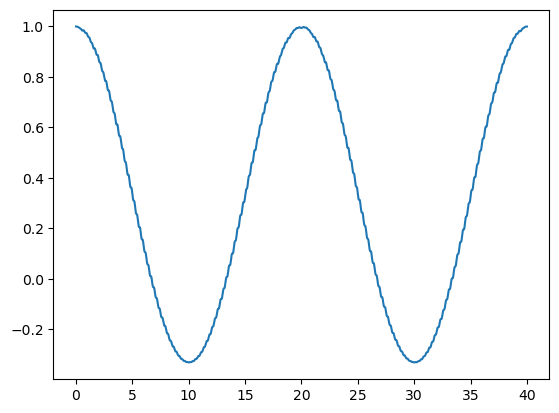

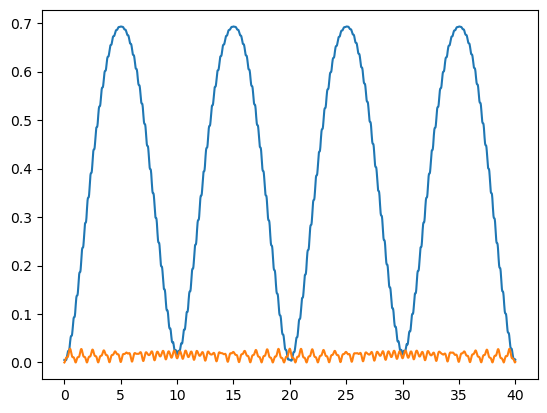

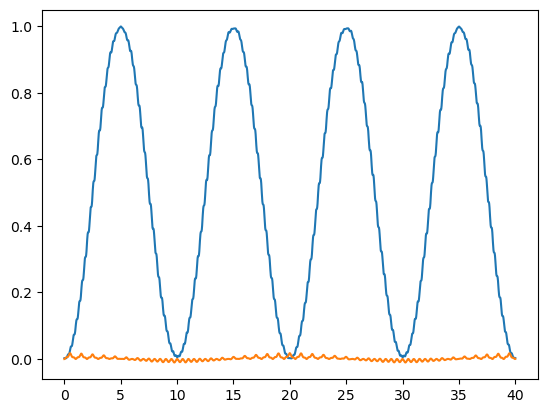

In [4]:
from __future__ import print_function,division 
" Copyright QuSpin Developers, GNU GPLv3 "

"Study the temperature dependence of the heating rate in the Bose Hubbard model"



import sys,os
import scipy.io as spio
import numpy as np
from quspin.tools.measurements import obs_vs_time
import pickle
from quspin.operators import hamiltonian
from quspin.operators import quantum_LinearOperator
from quspin.basis import boson_basis_1d # bosonic Hilbert space 
import time
import numpy as np # general math functions
import matplotlib.pyplot as plt # plotting library
from quspin.tools.Floquet import Floquet_t_vec # stroboscopic time vector

from quspin.operators import hamiltonian # Hamiltonians and operators
from quspin.basis import spin_basis_1d, spinless_fermion_basis_1d # Hilbert spacespin basis
import numpy as np # generic math functions
import matplotlib.pyplot as plt # plotting library
from quspin.tools.measurements import ent_entropy, diag_ensemble # entropies
dtype_real = np.float64
dtype_cmplx = np.result_type(dtype_real,np.complex64)
# #


L=3 # system size
J=0.1 # spin xx interaction
h=-1. # z magnetic field strength
g=0

Omega=2*h # drive frequency

T=2*np.pi/Omega



def drive(t,Omega):
	return np.cos(2*Omega*t)
drive_args=[Omega]


def drive2(t,Omega):
	return np.cos(1.*Omega*t)
drive_args2=[Omega]



"define site-coupling lists for operators"
x_field=[[g,i] for i in range(L)]
z_field=[[h,i] for i in range(L)]
J_nn3=[[J,i,(i+1)%L] for i in range(2,L-1)]

"define site-coupling lists for operators"
# "Full modulation"
# J_nn=[[-J,i,(i+1)%L] for i in range(L-1)] # OBC
# dynamic=[["xx",J_nn,drive,drive_args]]

#
#"Floquet dynammical dimerization"
J_nn1=[[J,i,(i+1)%L] for i in range(L-1)  if i % 2==0 ]
J_nn2=[[J,i,(i+1)%L] for i in range(L-1)  if i % 2==1 ]
#dynamic=[["xx",J_nn1,drive,drive_args],["xx",J_nn2,drive2,drive_args2]]

"Floquet dynammical dimerization"
#J_nn1=[[J,0,1%L]]
#J_nn2=[[J,1,2%L]]


dynamic=[["xx",J_nn1,drive,drive_args],["xx",J_nn2,drive2,drive_args2]]

# static and dynamic lists
static2=[["x",x_field],["z",z_field],["xx",J_nn1]]
static=[["x",x_field],["z",z_field]]





dynamic2=[]

"construct spin basis"
basis= spin_basis_1d(L=L,S='1/2',pauli=-1)    
###### construct Hamiltonian
H=hamiltonian(static,dynamic,dtype=np.float64,basis=basis)
H2=hamiltonian(static2,dynamic2,dtype=np.float64,basis=basis)


"Ground State of H2" 
E,V=H2.eigsh(time=0.0,k=1,which='SA')
psi_i=V[:,0]


"time_evolution until 100 period"
t=np.linspace(0,40*T,10000)
psi_t=H.evolve(psi_i,0,t)

Sent_args = {"basis":basis,"chain_subsys":[j for j in range(L//2)]}
"calculate entanglement entropy"
S={}
for j in range(1,L):    
    subsys = range(j)
    S[j-1] = ent_entropy(psi_t,basis,chain_subsys=subsys,alpha=1,density=False)["Sent"]



"Correlation between neighboring site"
CC={}

C={}

"<psi_t|S_i| psi_t>"
for i in range(L):    
    N = [(i)]
    Jz = [[1, i] for i in N]  # NN only, with OBC
    static3 = [["z", Jz]]
    HC = hamiltonian(static3, [], basis=basis)

    Obs_time2=obs_vs_time(psi_t,t,dict(E1=HC),return_state=True)
    Obs_time2=Obs_time2['E1']
    C[i]=Obs_time2
   
"<psi_t|Sz_i Sz_{i+1} | psi_t>  - <psi_t|Sz_{i+1} | psi_t> *  <psi_t|Sz_{i} | psi_t>  "
for i in range(L-1):

    NN_PAIRS = [(i, i+1)]
    Jzz = [[1, i, j] for (i, j) in NN_PAIRS]  # NN only, with OBC
    static2 = [["zz", Jzz]]
    basis = spin_basis_1d(L, S='1/2', pauli=True)
    HCC = hamiltonian(static2, [], basis=basis)
    Obs_time1=obs_vs_time(psi_t,t,dict(E1=HCC),return_state=True)
    Obs_time1=Obs_time1['E1']
    
    "<psi_t|S_i S_{i+1} | psi_t>  - <psi_t|S_{i+1} | psi_t> *  <psi_t|S_{i} | psi_t>  "
    CC[i]=Obs_time1 - C[i+1]*C[i]     
   


Lschd=np.zeros((1,len(t)))
for i in range(len(t)):
    Lschd[0,i]=abs(psi_t[:,i].transpose().conj()@psi_i)**2

Lschd=Lschd[0,:]
# "<psi_t|S_i| psi_t>    

        
#Obs_time=obs_vs_time(psi_t,t,dict(E1=H),return_state=True)


SZ = np.zeros(len(t))

for z in range(L):
    SZ = SZ +C[z]
#for z in range(L):
 #   plt.plot(t/T,C[z])
plt.figure()
plt.plot(t/T,SZ/L)

plt.figure()
for z in range(L-1):
    plt.plot(t/T,S[z])
    
plt.figure()
for z in range(L-1):
    plt.plot(t/T,CC[z])

results = [t,SZ,S]
# Save results using pickle
#with open("FDD-L12-QuSpin.pickle",'wb') as handle:
 #   pickle.dump(results, handle) 
        
        
        
        
        
        
        
        
        


In [2]:
plt.plot(t/T,S[L//2-1])

NameError: name 'plt' is not defined